<a href="https://colab.research.google.com/github/dolmani38/ai_corona/blob/master/analysis_corona_0506.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 1. Forecast with numeric timeseries data
# 1.1 Roaming Data의 load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
# custom R2-score metrics for keras backend
from keras import backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def plot_mae(hist):
    plt.plot(hist.history['mae'])
    plt.title('mean_absolute_error')
    plt.ylabel('mae')
    plt.xlabel('Epoch')
    plt.legend(['mae'], loc='upper right')
    plt.show()

def plot_r2(hist):
    plt.plot(hist.history['r2'])
    plt.title('R square')
    plt.ylabel('R^2')
    plt.xlabel('Epoch')
    #plt.legend(['mae'], loc='upper right')
    plt.show()

def compare_backdata(predit_y):
    predit = []
    for forecast in range(forecast_days):
        predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    comp_ds = raw_ds.copy()
    comp_ds['predict_arrival_1'] = predit[0]
    comp_ds['predict_arrival_15'] = predit[14]
    comp_ds.plot(y=['total','predict_arrival_1','predict_arrival_15'],figsize=(16,8))

def display_result(predit_y,title=None):
  predic_ds = []
  # 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
  #predit_y1 = predit_y * 100/24
  from datetime import datetime, timedelta
  last_date = raw_ds.index[-1]
  for predict_count in predit_y[0]:
    last_date += timedelta(days=1)
    predic_ds.append({'date':last_date,'roaming register forecate':predict_count, 'immigrantion forecast':int(predict_count * 100/24)})
  predic_ds = pd.DataFrame(predic_ds)
  predic_ds.plot(x='date',y='immigrantion forecast',kind='bar',title=('immigrantion forecast' if title is None else title))
  return predic_ds

class VerboseCallback(keras.callbacks.Callback):
    def __init__(self,epoch):
        self.epoch = epoch
        self.progress("learning:",0,[])
        
    def progress(self,text,current=0,log=None):
        pg = ['=' for i in range(current)] + ['.' for i in range(self.epoch-current)]
        print("\r" + str(text) + "[{}] {}/{} {}".format(''.join(pg),current,self.epoch, ('' if log is None else log)), end="", flush=True)
        if self.epoch-current == 0:
            print("")        
            
    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:",epoch+1,logs)



In [3]:
#공개된 Roaming Dataset을 읽고, 중간 중간 나온것을 합친다.
rm1 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm = pd.concat([rm1, rm2], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
217800,20200401,vn,20200330,20200401,3
217801,20200401,vn,20200331,20200331,20
217802,20200401,vn,20200331,20200401,6
217803,20200401,vn,20200401,20200401,45


In [4]:
# 1.2 Roaming Data에 대한 EDA
# 1.2.1 도착일을 기준으로 입국자(로밍등록자)의 합산

ar = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ar['date'] =  ar.index.astype('object')
#date column을 datetime 으로 casting 한다.
ar['date'] =  pd.to_datetime(ar['date'], format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ar

,count,date
arrival,,
20191031,91,2019-10-31
20191101,36,2019-11-01
20191102,120,2019-11-02
20191103,159,2019-11-03
20191104,179,2019-11-04
...,...,...
20200424,711,2020-04-24
20200425,463,2020-04-25
20200426,447,2020-04-26


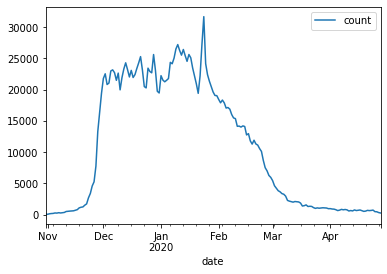

In [5]:
# 1.2.2 입국자(로밍등록자) 추세 chart 확인
ar.plot(x='date',y='count')

In [6]:
# 1.3 Roaming Data의 전처리
# 1.3.1 iso 별로 재배열

ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
    if date == row[0][0]:
        pass
    else:
        if not r is None:
            rows.append(r)
        r = {}
    r['arrival'] = row[0][0]
    r[row[0][1]] = row[1][0]
    date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso

,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,sk,...,tp,vu,zw,rs,tk,ug,bz,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,total
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.0,12.0,84,34.0,19.0,157,0.0,0.0,0.0,3.0,3.0,0.0,0.0,30.0,0.0,18,62.0,44.0,6.0,0.0,3.0,3.0,0.0,9.0,12.0,6.0,0.0,0.0,0.0,6.0,6.0,0.0,6.0,3.0,0.0,28.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711
2020-04-25,0.0,9.0,39,15.0,4.0,111,21.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,0.0,6,73.0,27.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463
2020-04-26,0.0,0.0,42,14.0,10.0,98,6.0,0.0,0.0,0.0,3.0,0.0,0.0,12.0,0.0,3,50.0,40.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,27.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447


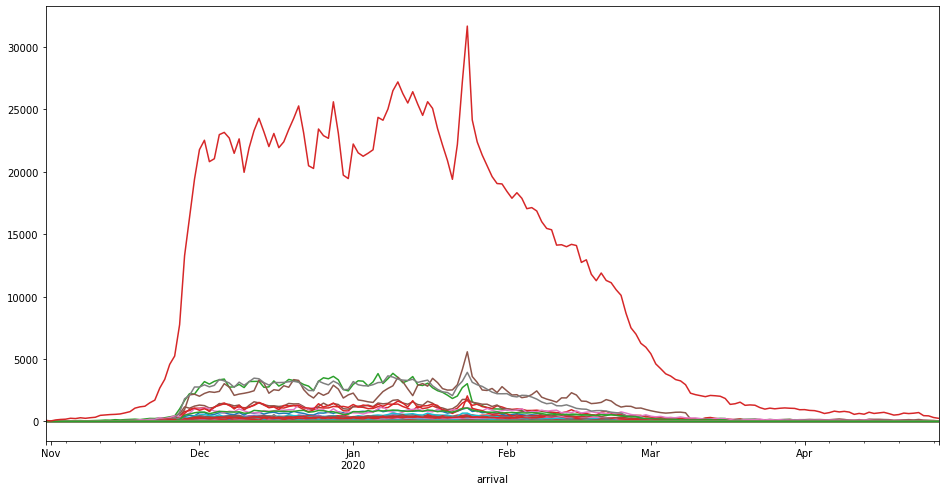

In [7]:
ds_iso.plot(legend=False,figsize=(16,8))

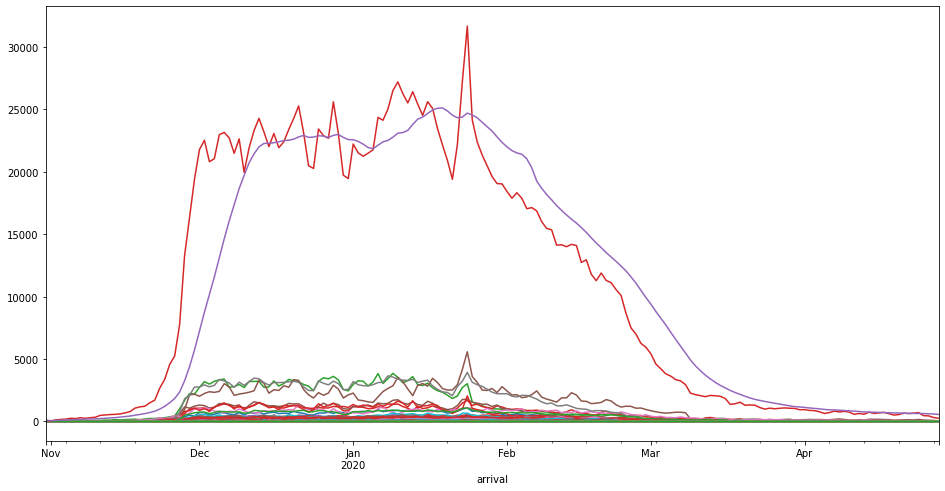

In [8]:
# 1.3.2 2주 (14일) 평균 추세 추가.
raw_ds = ds_iso.copy()
raw_ds['arrival_14ma'] = raw_ds['total'].rolling(window=14, min_periods=0).mean()
raw_ds.plot(legend=False,figsize=(16,8))

In [0]:
# 1.3.3 Trainingset의 구성

# Time-series CNN을 적용하기 위한 전처리
# 1D Convolution을 적용하기 위해.

import numpy as np

# window를 30일로 설정 -> 그냥 잡은 수치
window = 30
#입력 feature 개수.
size = len(raw_ds.columns) - 1 # totoal column 제외
#향후 15일 예측
forecast_days = 15


train_org_y = raw_ds['total'].to_numpy()
data = (raw_ds.drop(columns=['total'])).to_numpy()

train_x = []
train_y = []

for i in range(data.shape[0]-window-forecast_days + 1):
    sub_x = []
    for j in range(window):
        sub_x.append(data[i+j,:])
    train_x.append(sub_x)

    sub_y = []
    for z in range(forecast_days):
        sub_y.append(train_org_y[i + window + z])
    train_y.append(sub_y)

#train_x ,train_y의 준비
train_x = np.asarray(train_x)
train_x = train_x.reshape(-1,window,size)
train_y = np.asarray(train_y)

test_x = data[data.shape[0]-window:data.shape[0],:]

In [10]:
#train_x ,train_y의 내용 확인.
train_x.shape, train_y.shape, test_x.shape

((137, 30, 174), (137, 15), (30, 174))

In [11]:
# 1.4 CNN model 구성 

# custom R2-score metrics for keras backend
from keras import backend as K

# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,4, input_shape=(window, size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(32))
model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 128)           89216     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 64)            32832     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 32)            

In [12]:
# 1.5 model training
# 1.5.1 model training

#학습 시작...
epochs=50
hist = model.fit(train_x, train_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])

learning:[==================================================] 50/50 {'loss': 3526502.979927007, 'mae': 1258.2285, 'r2': 0.9636425}


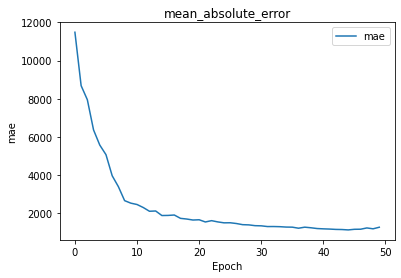

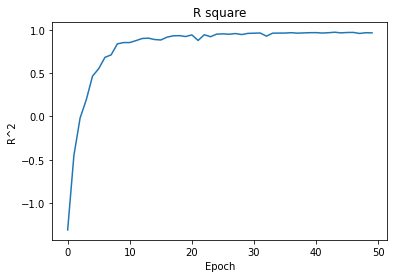

In [13]:
# 1.5.2 학습에 대한 mean_absolute_error 확인.
plot_mae(hist)
plot_r2(hist) 

In [14]:
# 1.5.3 trainset에 의한 과거 data의 예측 입국자 count 
predit_y = model.predict(train_x)
predit_y,predit_y.shape

(array([[15037.7    , 15924.336  , 14885.28   , ..., 17681.248  ,
         15718.195  , 15693.829  ],
        [18506.26   , 19294.697  , 18400.54   , ..., 21241.13   ,
         19297.15   , 19314.373  ],
        [20880.246  , 21438.61   , 20893.506  , ..., 23535.75   ,
         21924.639  , 22019.635  ],
        ...,
        [  647.8017 ,   577.69653,   612.32166, ...,   524.5046 ,
           483.223  ,   460.33533],
        [  615.7994 ,   561.8115 ,   585.4097 , ...,   501.53696,
           469.32877,   439.60077],
        [  597.3495 ,   554.31775,   571.1594 , ...,   483.70148,
           449.72464,   418.9013 ]], dtype=float32), (137, 15))

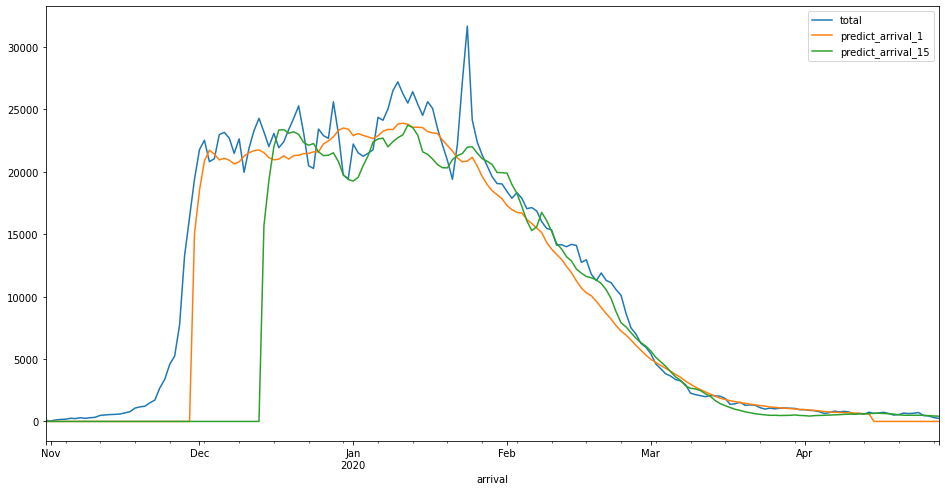

In [15]:
# 1.5.4 과거 Data에서 실등록자 count와 예측 count의 비교 

compare_backdata(predit_y)

In [16]:
# 1.6  향후 15일 예측
# 1.6.1 testset (마지막 30일)의 inference

# trainset의 마지막 날에서 15일까지의 예측
# 마지막 30일치 정보를 input으로...

test_x = test_x.reshape(-1,window,size)
predit_y = model.predict(test_x)
predit_y, predit_y.shape

(array([[404.08426, 402.97363, 391.25494, 389.70343, 384.92523, 359.1042 ,
         342.5591 , 307.24103, 361.15775, 315.1316 , 338.961  , 253.10626,
         271.98743, 299.42972, 246.13158]], dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,404.084259,1683
1,2020-04-30,402.973633,1679
2,2020-05-01,391.254944,1630
3,2020-05-02,389.703430,1623
4,2020-05-03,384.925232,1603
5,2020-05-04,359.104187,1496
6,2020-05-05,342.559113,1427
7,2020-05-06,307.241028,1280
8,2020-05-07,361.157745,1504
9,2020-05-08,315.131592,1313


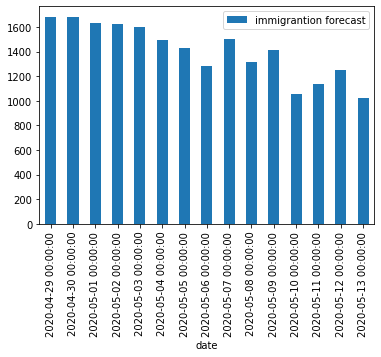

In [17]:
# 1.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [0]:

# 	2.1 News Data의 load

# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/NewsList.xls")
ns =pd.concat([ns1, ns2], ignore_index=True, sort=False)

In [19]:
ns

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
103822,XWFB2020040900020,"Ching Ming remembrance, home country forever! ...",http://wsjkw.sh.gov.cn/xwfb/20200404/2f54e0e14...,2020-04-09 16:05:21.0,2020-04-04 00:00:00,Shanghai Municioal Health Commission,COVID-19,Viral
103823,ZWYW2020041000002,Guangdong Provincial Health Commission notifie...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-10 18:00:45.0,2020-04-10 00:00:00,Health Commission of Guangdong Province,Dengue fever,Viral
103824,ZWYW2020041500002,Guangdong Provincial Health Commission announc...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:04.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral
103825,ZWYW2020041500003,Guangdong Provincial Health Commission release...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:13.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral


In [20]:
# 	2.2 News Data에 대한 EDA
# 		2.2.1 게시일을 기준으로 News buzz의 합산

cov_news = ns.loc[ns['감염병명'] == 'COVID-19']
cov_news['게시일자'] =  cov_news['게시일자'].str[:10]
cov_buz = pd.DataFrame(cov_news.groupby('게시일자')['감염병명'].count())
cov_buz = cov_buz.loc[cov_buz.index >= '2019-10-31']
cov_buz['date'] = pd.to_datetime(cov_buz.index, format='%Y-%m-%d')
cov_buz = cov_buz.rename(columns={"감염병명":"buz_count"})
cov_buz

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,buz_count,date
게시일자,,
2019-12-01,1,2019-12-01
2019-12-14,2,2019-12-14
2019-12-30,3,2019-12-30
2019-12-31,5,2019-12-31
2020-01-02,1,2020-01-02
...,...,...
2020-04-26,1176,2020-04-26
2020-04-27,1353,2020-04-27
2020-04-28,999,2020-04-28


In [21]:
# 		2.2.2 하루 최대 buzz count 추출

max_buz_per_day = cov_buz['buz_count'].max()
max_buz_per_day

1948

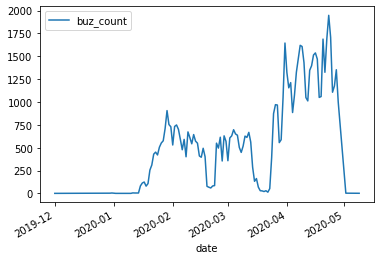

In [22]:
# 		2.2.3 News buzz 추세 Chart

cov_buz.plot(x='date',y='buz_count')

In [23]:
# Sentence Transformers: Multilingual Sentence Embeddings using BERT / RoBERTa / XLM-RoBERTa & Co. with PyTorch
# https://github.com/UKPLab/sentence-transformers

!pip install -U sentence-transformers

# BERT Test Code...

"""
This is a simple application for sentence embeddings: semantic search
We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.

This script outputs for various queries the top 5 most similar sentences in the corpus.
"""

from sentence_transformers import SentenceTransformer
import scipy.spatial

embedder = SentenceTransformer('bert-base-nli-mean-tokens')

# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'A cheetah is running behind its prey.'
          ]

corpus_embeddings = embedder.encode(corpus)

# Query sentences:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']
query_embeddings = embedder.encode(queries)

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
closest_n = 5

for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")
    for idx, distance in results[0:closest_n]:
        print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 573kB 6.5MB/s 
     |████████████████████████████████| 890kB 14.0MB/s 
     |████████████████████████████████| 3.7MB 16.5MB/s 
     |████████████████████████████████| 1.0MB 43.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=e5e2ff9a6df7673998d39a2d1b6e48e50882b732a56b3fd1d74572f443b713c4
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=de6a16783f8744338c5d9604ab7ba1096b501b58445284343e1ea94e337ad762
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


100%|██████████| 405M/405M [00:30<00:00, 13.1MB/s]






Query: A man is eating pasta.

Top 5 most similar sentences in corpus:
A man is eating a piece of bread. (Score: 0.8480)
A man is eating food. (Score: 0.7759)
Two men pushed carts through the woods. (Score: 0.2095)
A monkey is playing drums. (Score: 0.1945)
A man is riding a white horse on an enclosed ground. (Score: 0.1586)




Query: Someone in a gorilla costume is playing a set of drums.

Top 5 most similar sentences in corpus:
A monkey is playing drums. (Score: 0.7985)
A cheetah is running behind its prey. (Score: 0.2860)
The girl is carrying a baby. (Score: 0.2351)
A man is riding a horse. (Score: 0.2023)
A man is riding a white horse on an enclosed ground. (Score: 0.1963)




Query: A cheetah chases prey on across a field.

Top 5 most similar sentences in corpus:
A cheetah is running behind its prey. (Score: 0.9007)
Two men pushed carts through the woods. (Score: 0.3662)
A monkey is playing drums. (Score: 0.3061)
A man is riding a horse. (Score: 0.2930)
A man is riding a whit

In [24]:
# dolmani38의 google drive에서 corpus_embeddings.emb 의 다운로드
# corpus_embeddings.emb를 직접 만들거면 이 Cell은 실행 안해도 됨

!pip install PyDrive
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user(clear_output=False)
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({"id":"1FN7V0RxGACTNkusH9iQgFjXhicv1Lzei"})   # replace the id with id of file you want to access
downloaded.GetContentFile("corpus_embeddings.emb")        # replace the file name with your file

import os.path
from os import path

if path.exists("corpus_embeddings.emb"):
    print("Download complete!!")

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=OWCeWTgSvdlUQTI4UX6HqfI3prOsUv&code_challenge=exJnzDY3H6E4TRoxB3G1QjS-m6-DF923d3_H3utjl8g&prompt=consent&code_challenge_method=S256&access_type=offline

Enter verification code: ··········
Download complete!!


In [34]:
#			2.3.1.1 document의 tokenize & tagging
# 실 Contents는 사용하지 않고 title만 BERT embedding 처리...
import os.path
from os import path
import dill

temp_ds = cov_news #.head(10)
corpus = []
for row in temp_ds.iterrows():
    file_name = row[1][0]
    title = str(row[1][1])
    pub_datetime = row[1][4]
    corpus.append(title.lower())

if path.exists("corpus_embeddings.emb"):
    print("load from corpus_embeddings file...")
    file = open("corpus_embeddings.emb", 'rb')
    corpus_embeddings = dill.load(file)
    file.close()
    print("Complete!!")
else:
    corpus_embeddings = embedder.encode(corpus,show_progress_bar=True)   

    print("Wait! saving corpus_embeddings...")    
    file = open("corpus_embeddings.emb", 'wb')
    dill.dump(corpus_embeddings, file)
    file.close()
    print("Complete!!")

corpus_embeddings = np.asarray(corpus_embeddings)        
print("shape of corpus_embeddings : ",corpus_embeddings.shape)
print("length of corpus : ",len(corpus))

temp_ds = cov_news #.head(10)
docv_model = {}
for i, row in enumerate(temp_ds.iterrows()):
    docv_model[row[1][0]] = corpus_embeddings[i]

len(docv_model)

load from corpus_embeddings file...
Complete!!
shape of corpus_embeddings :  (73752, 768)
length of corpus :  73752


73306

In [35]:
# News에서 6개 feature 추출
# worse feature : 코로나 상황이 더 나빠지고 있다는 뉴스
# better feature : 상황이 좋아 지고 있나는 뉴스
# block feature : 격리, 입출입 차단 강화 관련 뉴스
# premit feature : 격리 해제, 입출입 완화 관련 뉴스
# yes_korea feature : 한국에 긍정적 내용 뉴스
# no_korea feature : 한국에 부정적 내용 뉴스

def searchSentence(queries,Threshold_score=0.60, Topn=0,must_has_word=[]):
    index = []
    query_embeddings = embedder.encode(queries)
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])
        
        for idx, distance in results[0:len(results) if Topn==0 else Topn]:
            if (1-distance) > Threshold_score:
                if len(must_has_word) > 0:
                    if corpus[idx].strip().find(must_has_word[0]) >= 0:
                        index.append(idx)
                else:
                    index.append(idx)
                #print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))
    return index

cov_news.reset_index(inplace = True, drop = True) 

worse = ['infected corona','infected coronavirus ','increase confirmed','increase Infections','infectious increase','confirmed case incease','deaths incease','patients incease','lack prepare','not prepared','lack medical','lack preparedness']
better = ['decrease confirmed','decrease Infections','infectious decrease','confirmed case decrease','No confirmed','No case','deaths decrease','patients decrease','send supplies','order supplies','donates supplies','gives supplies','situation stability','situation stable','remains stable']
block = ['immigrants block','immigrants restrict','immigration block','immigration restrict','entrants block','entrants restrict','entry block','entry restrict','tourist block','tourist restrict','tourist Isolation','traveler block','traveler restrict','traveler Isolation','immigrants quarantine','entrants quarantine','entry quarantine','tourist quarantine','reinforce quarantine','reinforce diagnosis']
permit = ['immigrants permit','immigrants ease','immigration permit','immigration ease','entrants permit','entrants ease','entry permit','entry ease','tourist permit','tourist ease','release tourist ','traveler permit','release quarantine','release quarantine']
yes_korea = ['korea decrease confirmed','korea decrease Infections','korea infectious decrease','korea confirmed case decrease','korea No confirmed','korea No case','korea deaths decrease','korea patients decrease','korea send supplies','korea order supplies','korea donates supplies','korea gives supplies','korea situation stability','korea situation stable','korea remains stable','korea immigrants permit','korea immigrants ease','korea immigration permit','korea immigration ease','korea entrants permit','korea entrants ease','korea entry permit','korea entry ease','korea tourist permit','korea tourist ease','korea release tourist ','korea traveler permit','korea release quarantine','korea release quarantine']
no_korea = ['korea infected corona','korea infected coronavirus ','korea increase confirmed','korea increase Infections','korea infectious increase','korea confirmed case incease','korea deaths incease','korea patients incease','korea lack prepare','korea not prepared','korea lack medical','korea lack preparedness','korea immigrants block','korea immigrants restrict','korea immigration block','korea immigration restrict','korea entrants block','korea entrants restrict','korea entry block','korea entry restrict','korea tourist block','korea tourist restrict','korea tourist Isolation','korea traveler block','korea traveler restrict','korea traveler Isolation','korea immigrants quarantine','korea entrants quarantine','korea entry quarantine','korea tourist quarantine','korea reinforce quarantine','korea reinforce diagnosis']

# Query sentences:
cov_news['worse'] = 0
idxs = searchSentence(worse)
print('worse result rows:{} query count:{}'.format(len(idxs),len(worse)))
cov_news.loc[idxs,'worse'] = 1

cov_news['better'] = 0
idxs = searchSentence(better)
print('better result rows:{} query count:{}'.format(len(idxs),len(better)))
cov_news.loc[idxs,'better'] = 1

cov_news['block'] = 0
idxs = searchSentence(block)
print('block result rows:{} query count:{}'.format(len(idxs),len(block)))
cov_news.loc[idxs,'block'] = 1

cov_news['permit'] = 0
idxs = searchSentence(permit)
print('permit result rows:{} query count:{}'.format(len(idxs),len(permit)))
cov_news.loc[idxs,'permit'] = 1

cov_news['yes_korea'] = 0
idxs = searchSentence(yes_korea,must_has_word=['korea'])
print('yes_korea result rows:{} query count:{}'.format(len(idxs),len(yes_korea)))
cov_news.loc[idxs,'yes_korea'] = 1

cov_news['no_korea'] = 0
idxs = searchSentence(no_korea,must_has_word=['korea'])
print('no_korea result rows:{} query count:{}'.format(len(idxs),len(no_korea)))
cov_news.loc[idxs,'no_korea'] = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


worse result rows:11805 query count:12


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


better result rows:1378 query count:15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


block result rows:2411 query count:20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


permit result rows:1210 query count:14


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


yes_korea result rows:574 query count:29


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


no_korea result rows:2049 query count:32


In [39]:
cov_1 = pd.DataFrame(cov_news.groupby('게시일자')['worse'].sum())
cov_2 = pd.DataFrame(cov_news.groupby('게시일자')['better'].sum())
cov_3 = pd.DataFrame(cov_news.groupby('게시일자')['block'].sum())
cov_4 = pd.DataFrame(cov_news.groupby('게시일자')['permit'].sum())
cov_5 = pd.DataFrame(cov_news.groupby('게시일자')['yes_korea'].sum())
cov_6 = pd.DataFrame(cov_news.groupby('게시일자')['no_korea'].sum())

cov_buz = cov_buz.join(cov_1).join(cov_2).join(cov_3).join(cov_4).join(cov_5).join(cov_6)
cov_buz

,buz_count,date,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,,,
2019-12-01,1,2019-12-01,0,0,0,0,0,0
2019-12-14,2,2019-12-14,0,0,0,0,0,0
2019-12-30,3,2019-12-30,1,0,0,0,0,0
2019-12-31,5,2019-12-31,3,0,0,0,0,0
2020-01-02,1,2020-01-02,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2020-04-26,1176,2020-04-26,78,7,11,7,0,3
2020-04-27,1353,2020-04-27,93,8,11,8,1,23
2020-04-28,999,2020-04-28,81,10,18,8,1,23


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

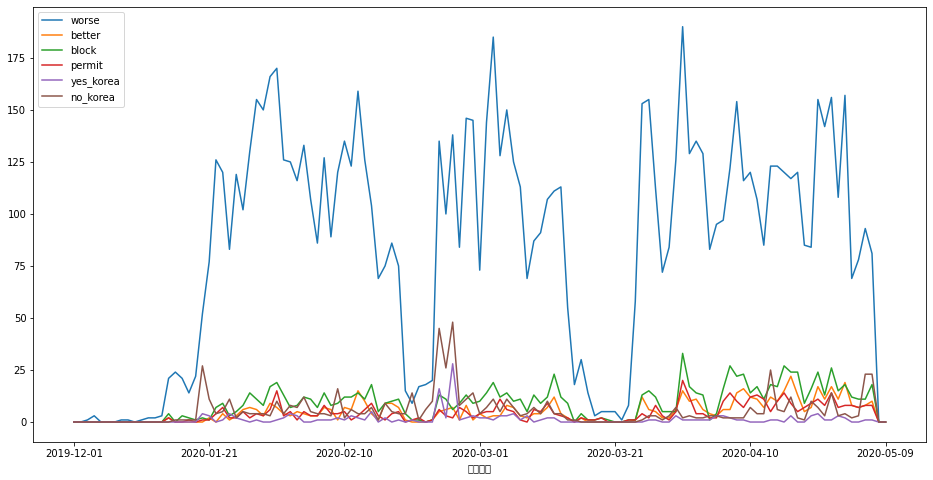

In [57]:
cov_buz.plot(y=['worse','better','block','permit','yes_korea','no_korea'],figsize=(16,8))

In [53]:
norm_cov_buz = pd.DataFrame({'worse':cov_buz['worse']/cov_buz['buz_count']})
norm_cov_buz["better"] = cov_buz['better']/cov_buz['buz_count']
norm_cov_buz["block"] = cov_buz['block']/cov_buz['buz_count']
norm_cov_buz["permit"] = cov_buz['permit']/cov_buz['buz_count']
norm_cov_buz["yes_korea"] = cov_buz['yes_korea']/cov_buz['buz_count']
norm_cov_buz["no_korea"] = cov_buz['no_korea']/cov_buz['buz_count']
norm_cov_buz

,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,
2019-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-30,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-31,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2020-04-26,0.066327,0.005952,0.009354,0.005952,0.000000,0.002551
2020-04-27,0.068736,0.005913,0.008130,0.005913,0.000739,0.016999
2020-04-28,0.081081,0.010010,0.018018,0.008008,0.001001,0.023023


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

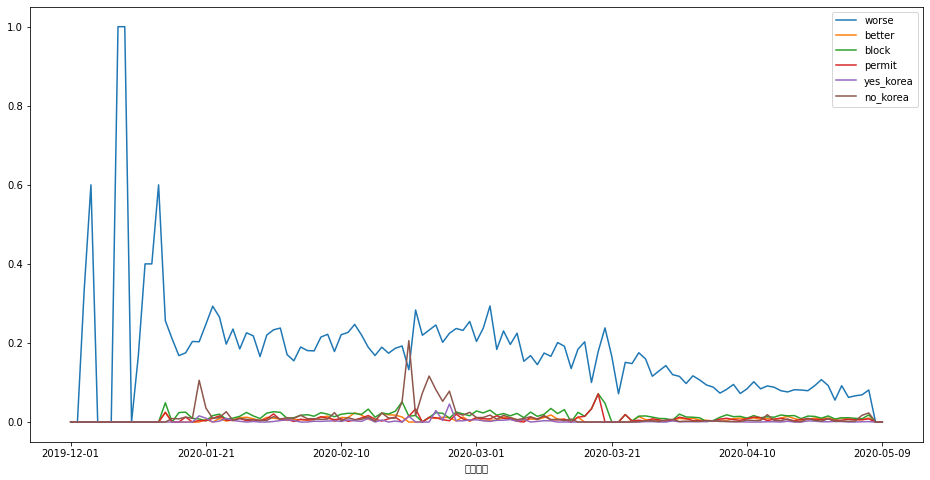

In [55]:
norm_cov_buz.plot(figsize=(16,8))

In [61]:
raw_ds_ns = raw_ds.join(norm_cov_buz)
raw_ds_ns = raw_ds_ns.fillna(0)
raw_ds_ns

,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,sk,...,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,total,arrival_14ma,worse,better,block,permit,yes_korea,no_korea
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91,91.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,63.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120,82.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159,101.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179,117.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.0,12.0,84,34.0,19.0,157,0.0,0.0,0.0,3.0,3.0,0.0,0.0,30.0,0.0,18,62.0,44.0,6.0,0.0,3.0,3.0,0.0,9.0,12.0,6.0,0.0,0.0,0.0,6.0,6.0,0.0,6.0,3.0,0.0,28.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711,638.071429,0.091920,0.011124,0.010539,0.004684,0.001171,0.002342
2020-04-25,0.0,9.0,39,15.0,4.0,111,21.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,0.0,6,73.0,27.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463,630.642857,0.062331,0.007227,0.010840,0.007227,0.000000,0.001807
2020-04-26,0.0,0.0,42,14.0,10.0,98,6.0,0.0,0.0,0.0,3.0,0.0,0.0,12.0,0.0,3,50.0,40.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,27.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447,616.785714,0.066327,0.005952,0.009354,0.005952,0.000000,0.002551


In [62]:
# Time-series CNN을 적용하기 위한 전처리
# 1D Convolution을 적용하기 위해.

import numpy as np

# window를 30일로 설정 -> 그냥 잡은 수치
window = 30
#입력 feature 개수.
size = len(raw_ds_ns.columns) - 1 # totoal column 제외
#향후 15일 예측
forecast_days = 15


train_org_y = raw_ds_ns['total'].to_numpy()
data = (raw_ds_ns.drop(columns=['total'])).to_numpy()

train_x = []
train_y = []

for i in range(data.shape[0]-window-forecast_days + 1):
    sub_x = []
    for j in range(window):
        sub_x.append(data[i+j,:])
    train_x.append(sub_x)

    sub_y = []
    for z in range(forecast_days):
        sub_y.append(train_org_y[i + window + z])
    train_y.append(sub_y)

#train_x ,train_y의 준비
train_x = np.asarray(train_x)
train_x = train_x.reshape(-1,window,size)
train_y = np.asarray(train_y)

test_x = data[data.shape[0]-window:data.shape[0],:]
#train_x ,train_y의 내용 확인.
train_x.shape, train_y.shape, test_x.shape

((137, 30, 180), (137, 15), (30, 180))

In [75]:

# custom R2-score metrics for keras backend
from keras import backend as K

# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,4, input_shape=(window, size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(32))
model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

print(model.summary())

model_json = model.to_json()
with open("combined_model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()

print("save to combined_model.json")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 30, 128)           92288     
_________________________________________________________________
activation_17 (Activation)   (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 15, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 15, 64)            32832     
_________________________________________________________________
activation_18 (Activation)   (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 7, 64)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 7, 32)            

In [77]:
#학습 시작...
def train_combined_model(trial,epochs=30,verbose=0,metrics=['mae',r2]):
    from keras.models import model_from_json
    json_file = open("combined_model.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=metrics)
    #print(model.summary())
    print(str(trial),"th Trial")
    if verbose == 0:
        hist = model.fit(train_x, train_y, epochs=epochs,verbose=0,callbacks=[VerboseCallback(epochs)])
    else:
        hist = model.fit(train_x, train_y, epochs=epochs,verbose=1)
    return model,hist

model,hist = train_combined_model(1,epochs=200)


1 th Trial
learning:[========================================================================================================================================================================================================] 200/200 {'loss': 1625104.0647810218, 'mae': 725.42346, 'r2': 0.9817446}


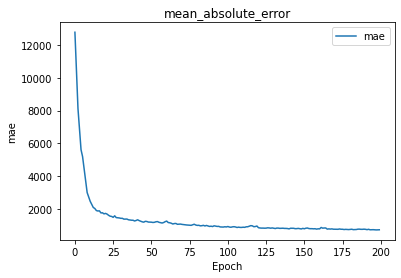

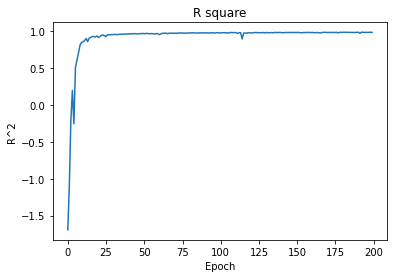

In [78]:
plot_mae(hist)
plot_r2(hist) 

In [79]:
predit_y = model.predict(train_x)
predit_y,predit_y.shape

(array([[19200.445  , 19751.959  , 21079.422  , ..., 22375.928  ,
         22192.584  , 21401.9    ],
        [20844.797  , 21603.303  , 22289.336  , ..., 23629.488  ,
         23434.355  , 22887.555  ],
        [21501.102  , 22420.486  , 22285.785  , ..., 23558.395  ,
         23495.95   , 23251.195  ],
        ...,
        [  539.5796 ,   525.4722 ,   482.07187, ...,   371.18887,
           372.70505,   360.13187],
        [  505.54382,   501.9375 ,   450.98053, ...,   357.8017 ,
           349.30713,   347.60852],
        [  478.8934 ,   483.34567,   422.5328 , ...,   345.57678,
           328.91196,   332.97678]], dtype=float32), (137, 15))

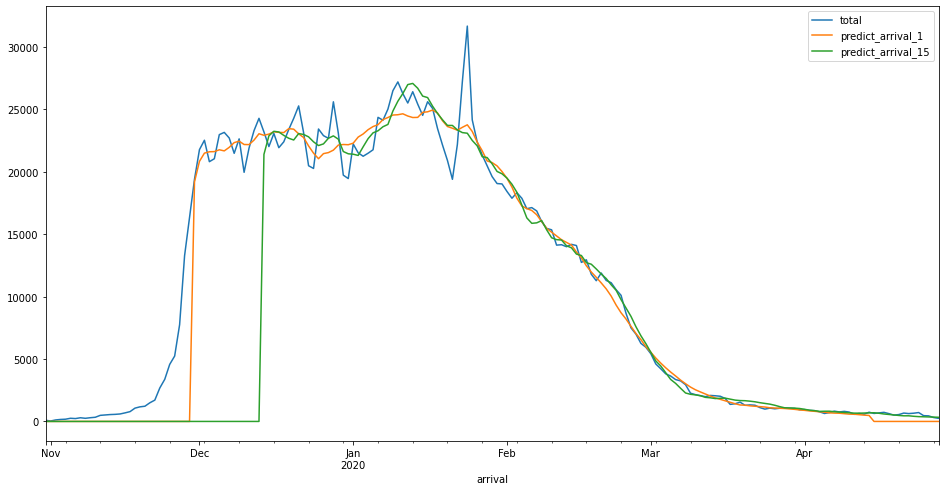

In [80]:
compare_backdata(predit_y)

In [81]:
test_x = test_x.reshape(-1,window,size)
predit_y = model.predict(test_x)
predit_y, predit_y.shape

(array([[303.37305, 334.2478 , 278.27747, 317.84995, 301.79596, 336.3524 ,
         262.70068, 315.83566, 298.7084 , 285.16855, 303.9148 , 275.49557,
         295.18683, 276.1057 , 253.03674]], dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,303.373047,1264
1,2020-04-30,334.247803,1392
2,2020-05-01,278.277466,1159
3,2020-05-02,317.849945,1324
4,2020-05-03,301.795959,1257
5,2020-05-04,336.352386,1401
6,2020-05-05,262.700684,1094
7,2020-05-06,315.835663,1315
8,2020-05-07,298.708405,1244
9,2020-05-08,285.168549,1188


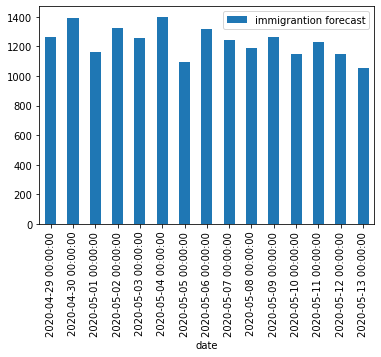

In [82]:
display_result(predit_y)

In [95]:
#	3.5 ensemble에 의한 일관된 결과 예측
#		3.5.1 ensemble model 생성

# 일관된 예측 결과를 만들기 위해, 동일 모델 10개의 앙상블 처리
# 시간 무지 오래 걸림 식사하고 오세요~
# 밥먹고 왔는데 중간에 실패 (Resource exhaustion) 되어 있을 수 있음...
# 너무 오래 걸리면, epoch=200 을 조정 한다.
import dill

ensemble = []
for i in range(10):
  model,hist = train_combined_model(i+1,epochs=200,verbose=0,metrics=['mae','acc'])
  ensemble.append(model)
    
print("Wait! saving model...")    
file = open("ensemble.mdl", 'wb')
dill.dump(ensemble, file)
file.close()
        
print("Complete!!")


1 th Trial
learning:[========================================================================================================================================================================================================] 200/200 {'loss': 1492585.6186131388, 'mae': 697.39594, 'acc': 0.35036495}
2 th Trial
learning:[========================================================================================================================================================================================================] 200/200 {'loss': 1585639.0821167883, 'mae': 710.1709, 'acc': 0.43065694}
3 th Trial
learning:[========================================================================================================================================================================================================] 200/200 {'loss': 1285003.3572080291, 'mae': 645.70123, 'acc': 0.4452555}
4 th Trial
learning:[==========================================================================================

In [96]:
if True == 1:
    print("load from model file...")
    file = open("ensemble.mdl", 'rb')
    ensemble = dill.load(file)
    file.close()

# 		ensemble_predict method define~
def ensemble_predict(input_x):

    ensemble_predit_y =  np.asarray([m.predict(input_x) for m in ensemble])
    predit_y = np.mean(ensemble_predit_y,axis=0)
    return predit_y, ensemble_predit_y

load from model file...


In [97]:
# trainset에 의한 과거 data의 예측 입국자 count 

predit_y,ensemble_predit_y = ensemble_predict(train_x)
predit_y,predit_y.shape

(array([[20129.934  , 20955.098  , 20991.688  , ..., 22855.078  ,
         22420.832  , 22156.855  ],
        [21363.719  , 21996.357  , 22265.95   , ..., 23815.066  ,
         23476.56   , 23149.54   ],
        [21635.453  , 21931.191  , 22371.053  , ..., 23560.479  ,
         23467.002  , 23112.32   ],
        ...,
        [  687.17395,   694.3151 ,   677.31506, ...,   432.62665,
           432.35187,   410.50555],
        [  667.4295 ,   674.33246,   657.51306, ...,   413.90845,
           411.67203,   393.1718 ],
        [  656.1728 ,   661.3589 ,   643.279  , ...,   408.66498,
           398.34366,   383.50674]], dtype=float32), (137, 15))

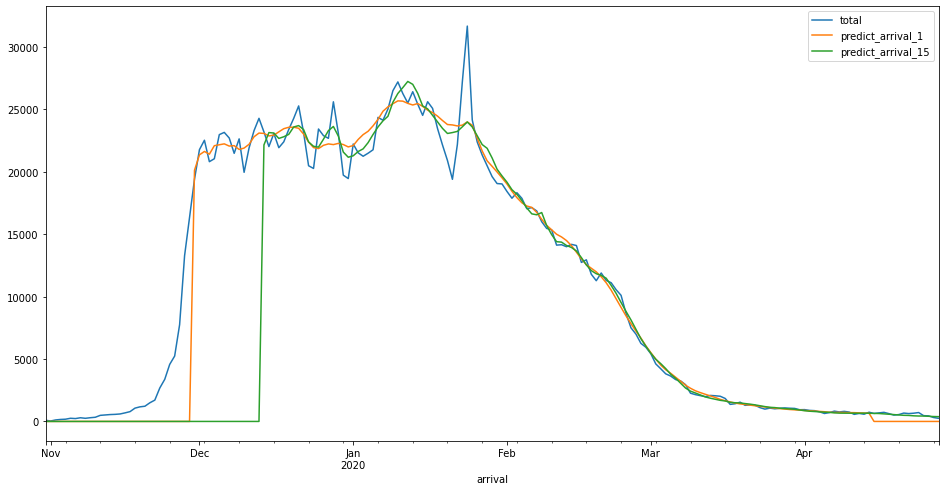

In [98]:
compare_backdata(predit_y)

In [99]:
# 
test_x = test_x.reshape(-1,window,size)

predit_y,ensemble_predit_y = ensemble_predict(test_x)
predit_y, predit_y.shape

(array([[420.36197, 431.71558, 435.1958 , 416.11533, 413.6971 , 397.23126,
         368.71725, 358.7357 , 352.87515, 349.16916, 331.13852, 313.0613 ,
         296.69324, 296.95047, 284.42007]], dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,420.361969,1751
1,2020-04-30,431.715576,1798
2,2020-05-01,435.195801,1813
3,2020-05-02,416.115326,1733
4,2020-05-03,413.697113,1723
5,2020-05-04,397.231262,1655
6,2020-05-05,368.717255,1536
7,2020-05-06,358.735687,1494
8,2020-05-07,352.875153,1470
9,2020-05-08,349.169159,1454


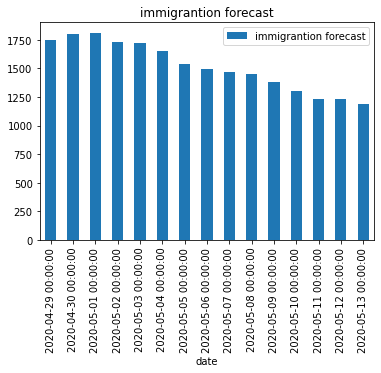

In [100]:
#		3.5.2 최종 결과
display_result(predit_y)

standard deviation in rows: [44.773 46.424 24.457 39.916 44.547 36.293 34.836 30.775 31.932 29.049
 43.187 35.929 40.826 39.37  39.453]
standard deviation: 6.1508827


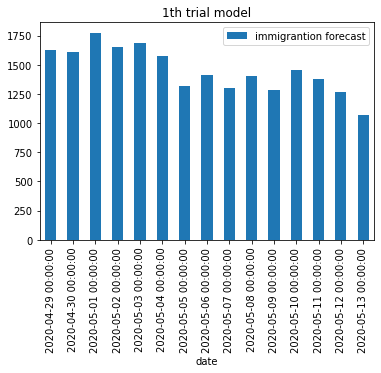

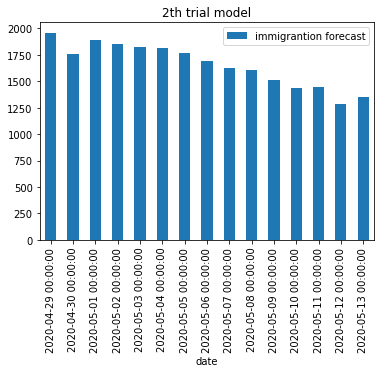

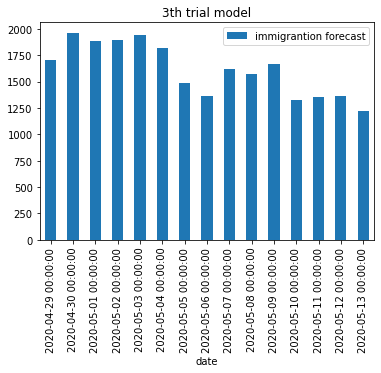

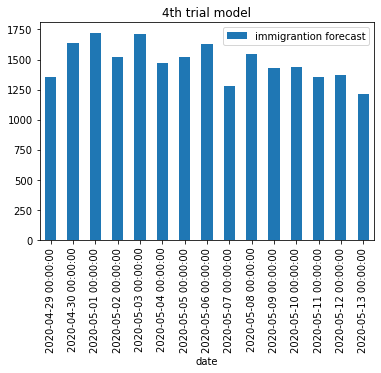

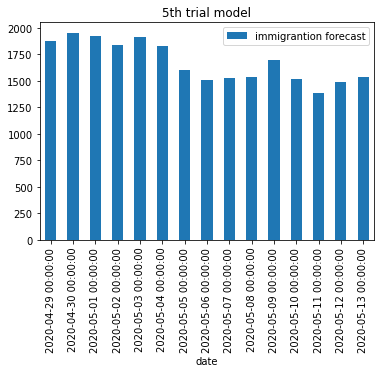

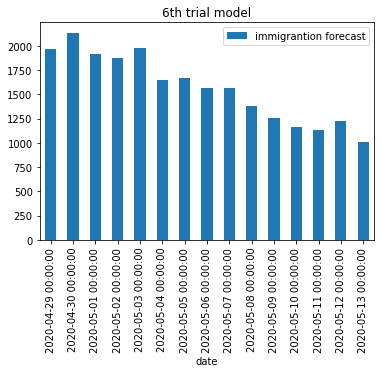

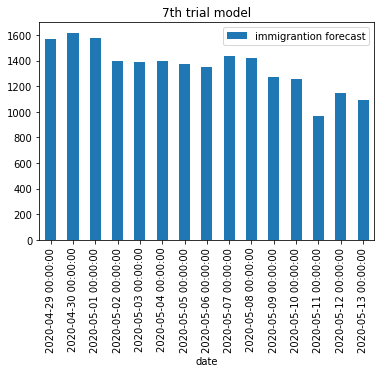

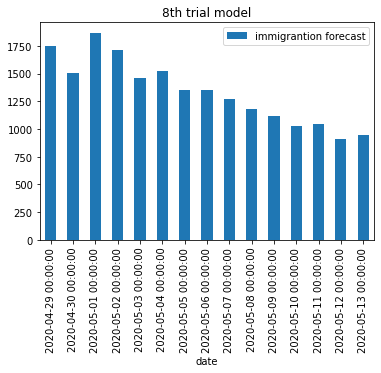

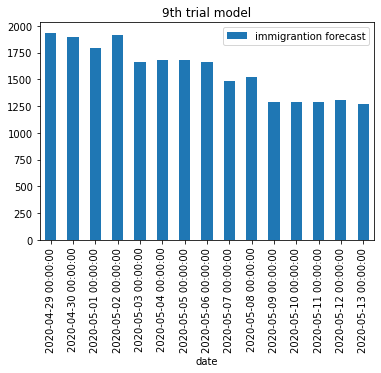

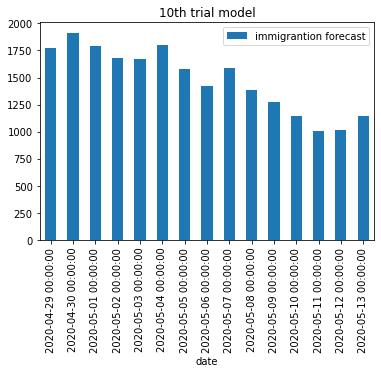

In [101]:

# 
for i,forecast in enumerate(ensemble_predit_y):
  display_result(forecast,title=str(i+1)+'th trial model')

# 표준편차 보기.
# 10개의 model이 비슷한 결과를 나타내면 std가 작아지고... 재각각이면 커짐
mstd = np.matrix(ensemble_predit_y).std(0).round(3)
print("standard deviation in rows:",mstd[0])
print("standard deviation:",np.std(mstd))